# Example : Estimating Projectile Velocity

You and your pal Jeff have been working on a spud cannon. You would like to estimate the muzzle velocity of your cannon so you can brag to your friends, but you don't have a way to measure it directly. 

## Projectile Model 

You mount the cannon at a fixed 45 degree angle and test fire enough spuds to feed a small village. You measure the distance traveled by each potato and find that the range to impact is normally distributed
\begin{equation}
x_{impact} \sim N \left (350, 5^2 \right ).
\end{equation}
To help you work out the muzzle velocity, you use a simple model of projectile motion with drag
\begin{equation}
\pmb{F} = m \pmb{g} - c | \pmb{v} |^2 \pmb{v}
\end{equation}
where $\pmb{F}$ is the net force on the spud, $m$ is its mass, $\pmb{v}$ is velocity, and $c$ is a drag coefficient.

In [5]:
import numpy as np
import numba

### Simulation Code
############################################################################

@numba.jit
def run_sim(v_mag, t_end):
    """ 
    Simulate a projectile with quadratic drag. Runs until the projectile hits the ground.
    v_mag is the initial speed. 
    """
    
    # State vector with position and velocity [x, y, v_x, v_y] 
    X = np.zeros(4)
    X[2:] = v_mag*np.array([np.sqrt(2.)/2., np.sqrt(2.)/2.])
    
    # Position through time
    xs = [0.]
    ys = [0.]
    
    # Run the model until the projectile hits the ground
    t = 0
    while t<t_end:
        X += rhs(X)
        t += dt

        xs.append(X[0])
        ys.append(X[1])
        
        if X[1] <= 0.0:
          break

    # Return trajectory
    return xs, ys

# Time step
dt = 0.01
# Gravitational constant
g = 9.81
# Projectile mass
m = 0.1
# Drag coefficient 
c = 8e-6


@numba.jit 
def rhs(X0):
    """ 
    RHS for equations of motion ODE.
    """

    # Position
    pos = X0[[0,1]]
    # Velocity
    v = X0[[2,3]]
    # Force 
    F = np.array([0., -m*g]) - c*np.linalg.norm(v + 1e-15)**2*v
    
    return np.block([v*dt, (F/m)*dt])


Here's an example of the model in action. 

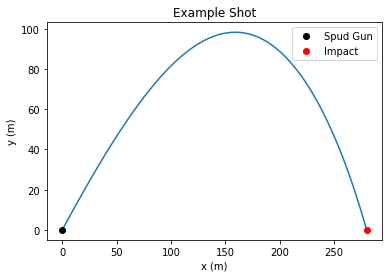

In [4]:
# Run a simulation 
xs, ys = run_sim(100., 20.)

# Plot it
import matplotlib.pyplot as plt
plt.title("Example Shot")
plt.plot(xs, ys)
plt.plot([0.], [0.], 'ko', label = 'Spud Gun')
plt.plot(xs[-1], [0.], 'ro', label = 'Impact')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.legend()
plt.show()

You and Jeff aren't sure what the muzzle velocity is off-hand, but you read on the highly reputable website spudfacts.com that a typical potato cannon has a muzzle velocity of 100 meters per second. You use the following iterative scheme to estimate the muzzle velocity for your cannon.  


Estimated Muzzle Velocity: 207.92990899327842 (m/s)
95\% Confidence Range: 173.59532102333347 - 242.26449696322337 (m/s)


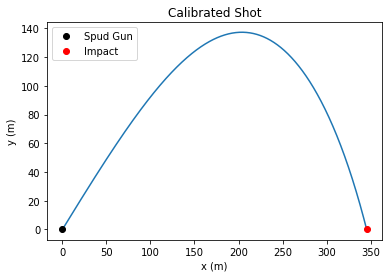

In [3]:
from filterpy.kalman.tut.sigma_transform import SigmaTransform
from filterpy.kalman.tut.tut_sigmas import TutSigmaPoints

# An initial guess
x0 = 100.
Px = 20.**2 
std = np.sqrt(Px)

# Nonlinear function 
def f(X):
    # Each column of X is a sigma point, and each column of Y is a transformed sigma point
    Y = np.zeros(X.shape[1])
    for i in range(X.shape[1]):
        x_i = X[:,i]
        xs, ys = run_sim(x_i, 20.)
        # Where the spud hits the ground
        Y[i] = xs[-1]
    return np.asarray([Y])

# Use a sigma point method to estimate joint distribution
st = SigmaTransform()
# Observation
yo = 350.
Q = 10.**2

for i in range(5):
    # Compute the joint distribution using a sigma point method
    joint_dist, X, wm, wc = st.do_transform(x0, Px, f, set_name = 'menegaz')
    # Condition on the observations
    cond_dist = joint_dist.get_conditional(yo, Q)
    # Update the estimated mean
    x0 = cond_dist.u0[0]

x_est = cond_dist.u0[0]
std_est = np.sqrt(cond_dist.Pu[0,0])
print("Estimated Muzzle Velocity: {} (m/s)".format(x_est))
print("95\% Confidence Range: {} - {} (m/s)".format(x_est - 2.*std_est, x_est + 2.*std_est))

xs, ys = run_sim(x_est, 20.)
plt.title("Calibrated Shot")
plt.plot(xs, ys)
plt.plot([0.], [0.], 'ko', label = 'Spud Gun')
plt.plot(xs[-1], [0.], 'ro', label = 'Impact')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
plt.legend()
plt.show()


Nice! The muzzle velocity is probably closer to 200 meters per second. Now that's something to brag about. 